In [1]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import sqlite3
from sqlite3 import Error

from scipy.spatial.distance import cosine
import collections

In [4]:

    
user_assesment = pd.read_csv("data/user_assessment_scores.csv")
user_interest = pd.read_csv("data/user_interests.csv")
user_view = pd.read_csv("data/user_course_views.csv")
course_df = pd.read_csv("data/course_tags.csv")


In [5]:
print(user_assesment.head(2))
print(user_interest.head(2))
print(user_view.head(2))
print(course_df.head(2))

   user_handle assessment_tag user_assessment_date  user_assessment_score
0         7487     angular-js  2017-08-11 19:03:38                    134
1         7487            css  2017-08-11 20:09:56                     38
   user_handle     interest_tag        date_followed
0            1  mvc-scaffolding  2017-06-27 16:26:52
1            1             mvc2  2017-06-27 16:26:52
   user_handle   view_date                                course_id  \
0            1  2017-06-27  cpt-sp2010-web-designers-branding-intro   
1            1  2017-06-28  cpt-sp2010-web-designers-branding-intro   

   author_handle     level  view_time_seconds  
0            875  Beginner               3786  
1            875  Beginner               1098  
                                        course_id   course_tags
0  12-principles-animation-toon-boom-harmony-1475  2d-animation
1              2d-racing-game-series-unity-5-1312   game-design


In [6]:
user_assesment['user_assesment_level'] = user_assesment.groupby(
    'assessment_tag')['user_assessment_score'].transform(lambda x:pd.cut(x, bins=5, labels=['1','2','3','4','5']))

In [7]:
user_assesment['user_assesment_level'] = user_assesment['user_assesment_level'].astype(str) +'/'+ user_assesment['assessment_tag'].map(str)

In [8]:
user_view.head(2)

user_handle   view_date                                course_id  \
0            1  2017-06-27  cpt-sp2010-web-designers-branding-intro   
1            1  2017-06-28  cpt-sp2010-web-designers-branding-intro   

   author_handle     level  view_time_seconds  
0            875  Beginner               3786  
1            875  Beginner               1098

In [9]:
user_view.level.unique()

array(['Beginner', 'Intermediate', 'Advanced'], dtype=object)

In [10]:
user_view.level = pd.Categorical(user_view.level)
user_view["level_codes"] = user_view.level.cat.codes

In [11]:
user_view.head(2)

user_handle   view_date                                course_id  \
0            1  2017-06-27  cpt-sp2010-web-designers-branding-intro   
1            1  2017-06-28  cpt-sp2010-web-designers-branding-intro   

   author_handle     level  view_time_seconds  level_codes  
0            875  Beginner               3786            1  
1            875  Beginner               1098            1

In [12]:
user_view['level_codes'] = user_view['level_codes'].astype(str) +'/'+ user_view['course_id'].map(str)

In [13]:
#join the user_assesment and user_interest dataframe
user_merged = pd.merge(user_assesment,user_interest,on='user_handle',how='outer')

In [14]:
print(user_merged.isnull().sum())

user_handle                   0
assessment_tag           185079
user_assessment_date     185079
user_assessment_score    185079
user_assesment_level     185079
interest_tag                  0
date_followed                 0
dtype: int64


In [15]:
user_merged_all = pd.merge(user_merged,user_view,on='user_handle',how='outer')

In [16]:
print(user_merged_all.isnull().sum())

user_handle                    0
assessment_tag           4008423
user_assessment_date     4008423
user_assessment_score    4008423
user_assesment_level     4008423
interest_tag                   0
date_followed                  0
view_date                  42972
course_id                  42972
author_handle              42972
level                      42972
view_time_seconds          42972
level_codes                42972
dtype: int64


In [17]:
factor_one = pd.get_dummies(user_assesment[['user_assesment_level','user_handle']], 
                   columns=['user_assesment_level']).groupby(['user_handle'], as_index=False).sum()

In [18]:
factor_two = pd.get_dummies(user_interest[['interest_tag','user_handle']], 
                   columns=['interest_tag']).groupby(['user_handle'], as_index=False).sum()

In [19]:
factor_three = pd.get_dummies(user_view[['level_codes','user_handle']], 
                   columns=['level_codes']).groupby(['user_handle'], as_index=False).sum()

In [20]:
factor_merge = pd.merge(factor_one,factor_two,on='user_handle',how='outer')

In [21]:
factor_merge_all = pd.merge(factor_merge,factor_three,on='user_handle',how='outer')

In [22]:
print(user_merged_all.isnull().sum())

user_handle                    0
assessment_tag           4008423
user_assessment_date     4008423
user_assessment_score    4008423
user_assesment_level     4008423
interest_tag                   0
date_followed                  0
view_date                  42972
course_id                  42972
author_handle              42972
level                      42972
view_time_seconds          42972
level_codes                42972
dtype: int64


In [23]:
factor_merge_all = factor_merge_all.fillna(0)

In [24]:
user_handle_values = factor_merge_all.user_handle.values

In [25]:
factor_merge_all = factor_merge_all.drop(['user_handle'],axis=1)

In [26]:
factor_sparse = csr_matrix(factor_merge_all)

In [27]:
tsvd = TruncatedSVD(n_components=factor_sparse.shape[1]-1)
# X_embedded = TSNE(n_components=X_sparse.shape[1]-1).fit_transform(X_sparse)

In [28]:
X_tsvd = tsvd.fit(factor_sparse)

In [29]:
tsvd_var_ratios = X_tsvd.explained_variance_ratio_

In [30]:
def select_n_components(var_ratio, goal_var):
   
    total_variance = 0.0
    
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [33]:
k_components = select_n_components(tsvd_var_ratios, 0.60)
print("The number of n-componenets needed to retain is : ",k_components)

('The number of n-componenets needed to retain is : ', 131)


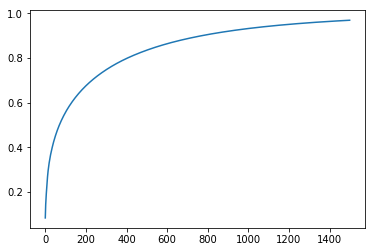

In [34]:
explained_variances = np.cumsum(X_tsvd.explained_variance_ratio_)
plt.plot(explained_variances[:1500], label='empirical explained variance')

In [35]:
factor_sparse_tsvd = TruncatedSVD(n_components=k_components, random_state=42).fit(factor_sparse)

In [37]:
factor_sparse_tsvd_features = factor_sparse_tsvd.transform(factor_sparse)

In [38]:
print(factor_sparse_tsvd_features.shape)

(10000, 131)


In [115]:
# factor_sparse_tsvd_features = np.array(factor_sparse_tsvd_features)
# factor_sparse_tsvd_features = np.insert(factor_sparse_tsvd_features, 0, user_handle_values, axis=1)

In [39]:
print(factor_sparse_tsvd_features.shape)

(10000, 131)


In [40]:
# import pickle
# f=open('data/feature_vectors','w')
# pickle.dump(factor_sparse_tsvd_features, f)
# f.close()

# f2 = open('test', 'r')
# s = pickle.load(f2)
# f2.close()
# factor_sparse_tsvd_features[]

factor_sparse_tsvd_features = np.hstack([user_handle_values.reshape(len(user_handle_values),1),factor_sparse_tsvd_features]) 
factor_sparse_tsvd_features =pd.DataFrame(factor_sparse_tsvd_features)

In [41]:
#Dataframe to csv
factor_sparse_tsvd_features.to_csv('data/feature_space.csv',sep=",",index=False)

In [126]:
# factor_sparse_tsvd_features.shape

(10000, 773)

In [129]:
# numpy_features = factor_sparse_tsvd_features.as_matrix(columns=None)

In [130]:
# numpy_features.shape

(10000, 773)

In [131]:
# def cosine_similarity_calculation(matrix,vector):

#     dotted = matrix.dot(vector)
#     matrix_norms = np.linalg.norm(matrix, axis=1)
#     vector_norm = np.linalg.norm(vector)
#     matrix_vector_norms = np.multiply(matrix_norms, vector_norm)
#     neighbors = np.divide(dotted, matrix_vector_norms)
#     return neighbors

In [144]:
# # for row in range(numpy_features.shape[0]):
# vector = numpy_features[56,:]
# matrix = numpy_features
# neighbors = cosine_similarity_calculation(matrix,vector)
# print(neighbors)
# neighbors_name ={v:neighbors[v] for v in range(len(neighbors))}
# print(neighbors_name)
# # neighbors_name.pop(0)
# top_features = collections.Counter(neighbors_name)
# top_features_k = top_features.most_common(50)
# top_features_k.pop(0)
# print("-------------------------------")
# print(top_features_k)
# # print(user_handle_values[3939])
    
    

[ 0.11449287  0.43918631  0.85054748 ...,  0.99766128  0.99765518
  0.99765553]
{0: 0.1144928742185455, 1: 0.43918630789365887, 2: 0.85054748275324299, 3: 0.65741361638090223, 4: 0.94448025955870107, 5: 0.66525447183502462, 6: 0.43695320759956208, 7: 0.6159837310450107, 8: 0.9625846967879752, 9: 0.97922148355732586, 10: 0.99682298394460422, 11: 0.9069359177924069, 12: 0.9256925003887807, 13: 0.99484595651506624, 14: 0.98425850496460232, 15: 0.95171126152404029, 16: 0.96536920491981093, 17: 0.98612994264054121, 18: 0.99589862173285049, 19: 0.96914889293218298, 20: 0.90803953419059924, 21: 0.97101290884324354, 22: 0.99191193605591499, 23: 0.994545416681068, 24: 0.99408542099518316, 25: 0.93245043867296096, 26: 0.99327285239873853, 27: 0.99436650398450843, 28: 0.98924653304685517, 29: 0.99623288843137447, 30: 0.99519617260078419, 31: 0.99282737704351787, 32: 0.99402328056003031, 33: 0.92272004624006976, 34: 0.99142469684134105, 35: 0.80240032245377479, 36: 0.99728452594574979, 37: 0.99640